In [1]:
import pandas as pd
import numpy as np

# 1

In [2]:
data=pd.read_csv('Housing.csv')
row=[]
c=data.loc[:, data.isnull().any()].columns
for i in c:
    for j in range(len(data[i])):
        if(pd.isna(data[i][j])==True):
            row.append(j)
row=set(row) 
data=data.drop(row)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 59.6+ KB


In [3]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
l=[]
for i in data:
    if data.dtypes[i]=='object':
        l.append(i)
        data[i]=le.fit_transform(data[i])
     
       

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
l=[]
o=data.select_dtypes(include=object).columns
a=list(o)
for i in data:
    if(i not in a):
        l.append(i)
model=scaler.fit(data[l])
data[l]=model.transform(data[l])
#print(data['price'])

In [5]:
def mse(y):
    return np.var(y)
def info_gain(parent,left,right):
    p_left = len(left) / len(parent)
    p_right = len(right) / len(parent)
    return mse(parent) - (p_left*mse(left) + p_right*mse(right))

In [6]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value
def best_split(dataset, num_features):
        bestsplit = {}
        gain = -2000000
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            thresholds = np.linspace(min(feature_values),max(feature_values),num=25)
            for i in thresholds:
                left = np.array([row for row in dataset if row[feature_index]<=i])
                right = np.array([row for row in dataset if row[feature_index]>i])
                if len(left)>0 and len(right)>0:
                    y, left_y, right_y = dataset[:, -1], left[:, -1], right[:, -1]
                    curr_info_gain = info_gain(y, left_y, right_y)
                    if curr_info_gain>gain:
                        bestsplit["feature_index"] = feature_index
                        bestsplit["threshold"] = i
                        bestsplit["left"] = left
                        bestsplit["right"] = right
                        bestsplit["info_gain"] = curr_info_gain
                        gain = curr_info_gain
        return bestsplit

In [7]:
def tree(dataset, curr_depth=0,max_depth=10,min_samples_split=2):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        if num_samples>=min_samples_split and curr_depth<=max_depth:
            bestsplit = best_split(dataset, num_features)
            if(bestsplit!={}):
                if bestsplit["info_gain"]>0:
                    left_subtree = tree(bestsplit["left"], curr_depth+1,max_depth)
                    right_subtree = tree(bestsplit["right"], curr_depth+1,max_depth)
                    return Node(bestsplit["feature_index"], bestsplit["threshold"], left_subtree, right_subtree, bestsplit["info_gain"])

        leaf=np.mean(Y)
        #print(max_depth)
        return Node(value=leaf)
        

In [8]:
def predict(x,root):
    if root.value!=None: 
        return root.value
    feature_val = x[root.feature_index]
    if feature_val<=root.threshold:
        return predict(x, root.left)
    else:
        return predict(x, root.right)

In [9]:
data=np.array(data)

from sklearn.model_selection import train_test_split
data_train,data_test = train_test_split(data, test_size=0.2, random_state=46)
X_train=data_train[:,1:]
Y_train=data_train[:,0]
Y_train=Y_train.reshape(len(Y_train),1)
X_test=data_test[:,1:]
Y_test=data_test[:,0]
dataset = np.concatenate((X_train, Y_train), axis=1)

root =tree(dataset)


In [10]:
predictions=[predict(i,root) for i in X_test]
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, predictions)

0.010607092744498373

In [11]:
from sklearn.metrics import r2_score
print("R-squared score : ",'%.10f'%r2_score(Y_test,predictions),"\n")

R-squared score :  0.5235649367 



In [12]:
import random
import copy
from random import randrange
random.seed(100)
def cross_validation_split(da, folds):
    d_split =[]
    d_copy = copy.deepcopy(list(da))
    size = int(len(da) / folds)
    
    for i in range(folds):
        fold = []
        while len(fold) < size:
            index = randrange(len(d_copy))
            fold.append(d_copy.pop(index))
        d_split.append(fold)
    return d_split

data_split=cross_validation_split(dataset, 5)
data_split=np.array(data_split)


0.014618574223383822
8
0.5904181740932697


Text(0, 0.5, 'Mean R2')

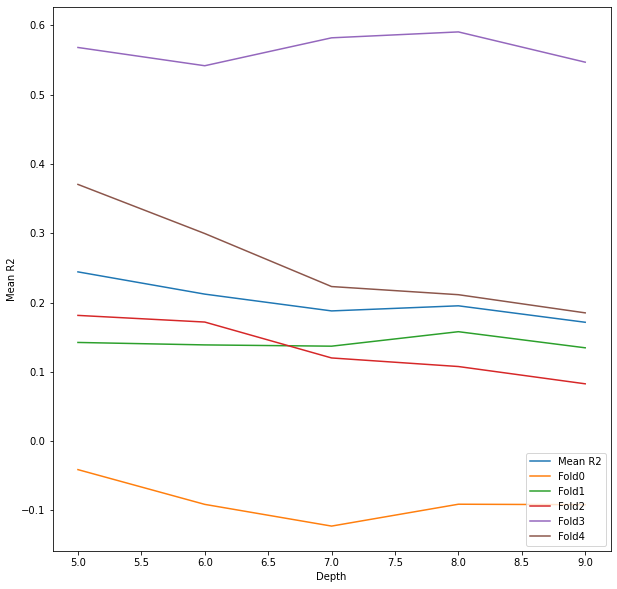

In [14]:
import matplotlib.pyplot as plt
md=-10000
mse1=10000
r2score=-10
r2s=[]
md1=[5,6,7,8,9]
for i in range(len(data_split)):
    x_train=np.vstack(data_split[(i+1)%5])
    for j in range(5):
        if(j!=i and j!=(i+1)%5):
            x_train=np.vstack((x_train,data_split[j]))        
    x_test=np.vstack(data_split[i])
    l1=[]
    for k in range(5,10):
        root1 =tree(x_train,max_depth=k)
        Y1 = x_test[:, -1]
        Y1=Y1.reshape(len(Y1),1)
        prediction=[predict(i,root1) for i in x_test[:,:-1]]
        rs=r2_score(Y1,prediction)
        l1.append(rs)
        m=mean_squared_error(Y1, prediction)
        if(rs>r2score):
            mse1=m
            md=k
            r2score=r2_score(Y1,prediction)
    r2s.append(l1)        
r2s1=[]
for i in range(5):
    s=0
    for j in range(5):
        s+=r2s[j][i]
    r2s1.append(s/5)    
    
        

print(mse1)
print(md)
print(r2score)
plt.figure(figsize=(10,10))
fig2 = plt.plot(md1, r2s1, linestyle='solid')
fig3 = plt.plot(md1, r2s[0], linestyle='solid')
fig4 = plt.plot(md1, r2s[1], linestyle='solid')
fig5 = plt.plot(md1, r2s[2], linestyle='solid')
fig6 = plt.plot(md1, r2s[3], linestyle='solid')
fig7 = plt.plot(md1, r2s[4], linestyle='solid')
plt.legend(["Mean R2", "Fold0","Fold1","Fold2","Fold3","Fold4"], loc ="lower right")
plt.xlabel("Depth")
plt.ylabel("Mean R2")
    
    

Average r2_score : 0.2980620555436034
r2_score(After Bagging) : 0.6299390145303544


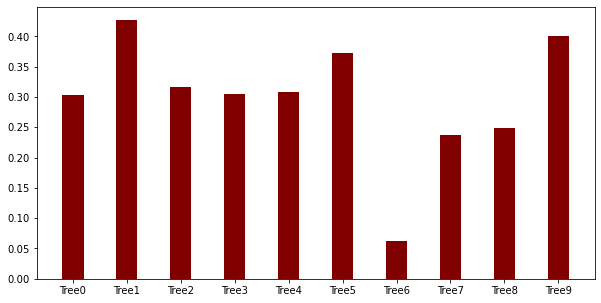

In [14]:
random.seed(50)
#bagging 
def bag(d):
    t =[]
    n_sample = round(len(d) * 1)
    while len(t) < n_sample:
        index = randrange(len(d))
        t.append(d[index])
    return np.array(t)   
n_estimators = 10
sum_r2scores=0
v=[]
DTs=[]
pred=[]
for i in range(n_estimators):
    t=bag(dataset)
    x=t[:,:-1]
    y=t[:,-1]
    y=y.reshape(len(y),1)
    regressor = tree(np.concatenate((x, y), axis=1))
    DTs.append(regressor)
    p=[predict(i,regressor) for i in X_test]
    pred.append(p)
    r2 = r2_score(Y_test, p)
    v.append(r2)
    sum_r2scores+=r2
courses = list('Tree'+str(i) for i in range(10))
values = v
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(courses, values, color ='maroon',width = 0.4)    
pred=np.array(pred)
x=np.mean(pred,axis=0)
r2 = r2_score(Y_test, x)
print("Average r2_score : "+str(sum_r2scores/10))
print("r2_score(After Bagging) : "+str(r2))

Text(0.5, 0, 'max_depth')

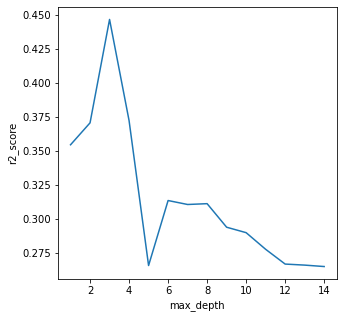

In [15]:

max_r2s=-10
b1=0
lol=[]
lmao=[]
for j in range(1,15):
    l1=[]
    for i in range(n_estimators):
        random.seed(100)
        t=bag(dataset)
        x=t[:,:-1]
        y=t[:,-1]
        y=y.reshape(len(y),1)
        regressor = tree(np.concatenate((x, y), axis=1),max_depth=j)
        p=[predict(i,regressor) for i in X_test]
        l1.append(p)
    l1=np.array(l1)
    xd=np.mean(l1,axis=0)
    r2=r2_score(Y_test,xd)
    lmao.append(r2)
    lol.append(j)
plt.figure(figsize=(5,5))
fig2 = plt.plot( lol, lmao,linestyle='solid')
plt.ylabel("r2_score")
plt.xlabel("max_depth")


In [16]:
from sklearn.ensemble import RandomForestRegressor
regres = RandomForestRegressor(random_state=5)
regres.fit(X_train,Y_train)
Pred_Price = regres.predict(X_test)
rsc = r2_score(Pred_Price, Y_test)
m1=mean_squared_error( Y_test,Pred_Price)
print(rsc)
print(m1)

0.33190327492441274
0.008148866299111865


<ipython-input-16-743d51e890ba>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regres.fit(X_train,Y_train)


In [17]:
from sklearn.ensemble import AdaBoostRegressor
ADB = AdaBoostRegressor(random_state=42)
ADB_model = ADB.fit(X_train,Y_train)
y_pred=ADB_model.predict(X_test)
rsc1 = r2_score(Y_test,y_pred)
m2=mean_squared_error(Y_test,y_pred)
print(m2)
print(rsc1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.01237186920391076
0.44429709166009346


# 2

In [19]:
data1=pd.read_csv('Breast_cancer_data.csv')
row=[]
c=data1.loc[:, data1.isnull().any()].columns
for i in c:
    for j in range(len(data1[i])):
        if(pd.isna(data1[i][j])==True):
            row.append(j)
row=set(row) 
data1=data1.drop(row)
data1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 31.1 KB


In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
l1=[]
o1=data1.select_dtypes(include=object).columns
a1=list(o1)
for i in data1:
    if(i not in a1):
        l1.append(i)
model=scaler.fit(data1[l1])
data1[l1]=model.transform(data1[l1])
li=[]
index=0
for i in data1:
    if data1[i].dtype=='float64':
        li.append(index)
        index+=1
    else:
        index+=1

In [21]:
def gini_index(y):
    a,counts = np.unique(y,return_counts=True)

    probabilities = counts/counts.sum()
    gini = sum(probabilities**2)
    return 1-gini
def info_gain1(parent,left,right):
    p_left = len(left) / len(parent)
    p_right = len(right) / len(parent)
    return gini_index(parent) - (p_left*gini_index(left) + p_right*gini_index(right))

In [22]:
def best_split1(dataset, num_features):
        bestsplit = {}
        gain = -2000000
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            thresholds = np.linspace(min(feature_values),max(feature_values),num=25)
            for i in thresholds:
                left = np.array([row for row in dataset if row[feature_index]<=i])
                right = np.array([row for row in dataset if row[feature_index]>i])
                if len(left)>0 and len(right)>0:
                    y, left_y, right_y = dataset[:, -1], left[:, -1], right[:, -1]
                    curr_info_gain = info_gain1(y, left_y, right_y)
                    if curr_info_gain>gain:
                        bestsplit["feature_index"] = feature_index
                        bestsplit["threshold"] = i
                        bestsplit["left"] = left
                        bestsplit["right"] = right
                        bestsplit["info_gain"] = curr_info_gain
                        gain = curr_info_gain
        return bestsplit

In [23]:
def tree1(dataset, max_depth,curr_depth=0,min_samples_split=2):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        if num_samples>=min_samples_split and curr_depth<=max_depth:
            bestsplit = best_split1(dataset, num_features)
            if(bestsplit!={}):
                if bestsplit["info_gain"]>0:
                    left_subtree = tree1(bestsplit["left"], max_depth,curr_depth+1)
                    right_subtree = tree1(bestsplit["right"], max_depth,curr_depth+1)
                    return Node(bestsplit["feature_index"], bestsplit["threshold"], left_subtree, right_subtree, bestsplit["info_gain"])

        Y = list(Y)
        leaf=max(Y, key=Y.count)
        return Node(value=leaf)
        

In [24]:
data1=np.array(data1)
data1_train,data1_test = train_test_split(data1, test_size=0.2, random_state=41)
X1_train=data1_train[:,:-1]
Y1_train=data1_train[:,-1]
Y1_train=Y1_train.reshape(len(Y1_train),1)
X1_test=data1_test[:,:-1]
Y1_test=data1_test[:,-1]
dataset1 = np.concatenate((X1_train, Y1_train), axis=1)
root1 =tree1(dataset1,5)
print(dataset1)

[[0.27682332 0.20358471 0.27019556 0.15414634 0.3409768  1.        ]
 [0.34450282 0.28610078 0.32775897 0.20767762 0.1185339  1.        ]
 [0.31563254 0.1166723  0.30467832 0.18044539 0.39568475 1.        ]
 ...
 [0.32036537 0.47548191 0.30923917 0.18939555 0.25097048 1.        ]
 [0.62373988 0.33648969 0.60334462 0.4795334  0.2488941  0.        ]
 [0.21151025 0.38079134 0.20744938 0.10943796 0.51972556 1.        ]]


In [25]:
predictions1=[predict(i,root1) for i in X1_test]
from sklearn.metrics import accuracy_score
accuracy_score(Y1_test, predictions1)

0.9210526315789473

In [26]:
random.seed(100)
data_split1=cross_validation_split(dataset1, 5)
data_split1=np.array(data_split1)


4
0.967032967032967


Text(0, 0.5, 'Mean R2')

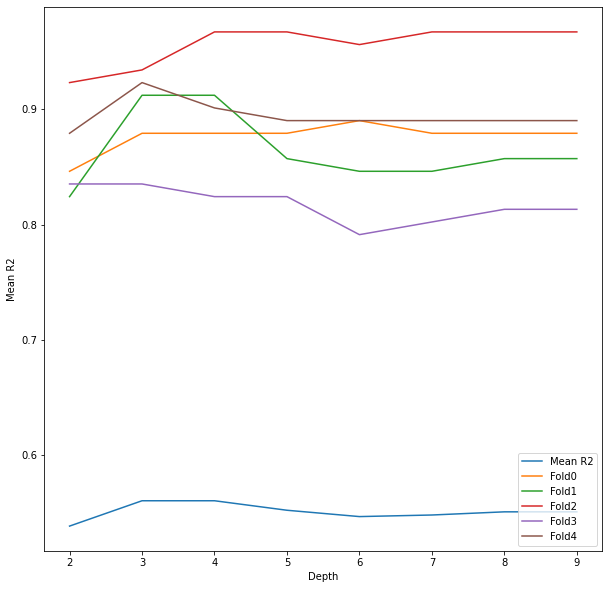

In [27]:
mD=-10000
r2score1=-10
r=[]
md1=[2,3,4,5,6,7,8,9]
for i in range(len(data_split1)):
    x_train=np.vstack(data_split1[(i+1)%5])
    for j in range(5):
        if(j!=i and j!=(i+1)%5):
            x_train=np.vstack((x_train,data_split1[j]))        
    x_test=np.vstack(data_split1[i])
    l1=[]
    #print(x_train)
    for k in range(2,10):
        root1 =tree1(x_train,k)
        Y1 = x_test[:, -1]
        Y1=Y1.reshape(len(Y1),1)
        prediction=[predict(i,root1) for i in x_test[:,:-1]]
        rs=accuracy_score(Y1, prediction)
        #print(rs)
        l1.append(rs)
        if(rs>r2score1):
            mD=k
            r2score1=rs
    r.append(l1)        
r1=[]
for i in range(8):
    s=0
    for j in range(5):
        s+=r[j][i]
    r1.append(s/8)    
    
print(mD)
print(r2score1)
plt.figure(figsize=(10,10))
fig2 = plt.plot(md1, r1, linestyle='solid')
fig3 = plt.plot(md1, r[0], linestyle='solid')
fig4 = plt.plot(md1, r[1], linestyle='solid')
fig5 = plt.plot(md1, r[2], linestyle='solid')
fig6 = plt.plot(md1, r[3], linestyle='solid')
fig7 = plt.plot(md1, r[4], linestyle='solid')
plt.legend(["Mean R2", "Fold0","Fold1","Fold2","Fold3","Fold4"], loc ="lower right")
plt.xlabel("Depth")
plt.ylabel("Mean R2")
    
    

In [28]:
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
my_model = xgb.XGBClassifier(subample=0.7,max_depth=4)
my_model.fit(X1_train, Y1_train)
y_pre = my_model.predict(X1_test)
acc=accuracy_score(Y1_test,y_pre)
print(acc)

[16:19:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "subample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:19:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9298245614035088


In [29]:
from lightgbm import LGBMClassifier
for num_leaves in range(2,11):
    model = LGBMClassifier(max_depth=3,num_leaves=num_leaves)
    model.fit(X1_train, Y1_train)
    p1 = model.predict(X1_test)
    print(accuracy_score(Y1_test,p1))

0.956140350877193
0.9385964912280702
0.9298245614035088
0.9473684210526315
0.9385964912280702
0.9473684210526315
0.9385964912280702
0.9385964912280702
0.9385964912280702


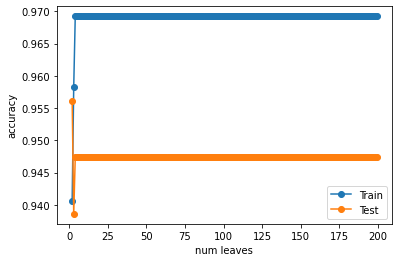

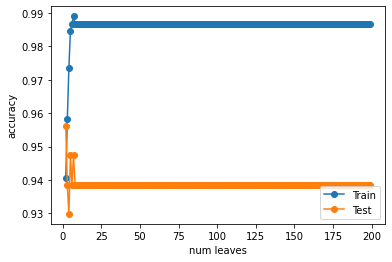

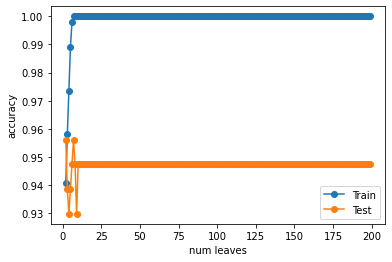

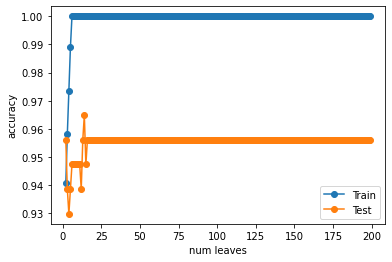

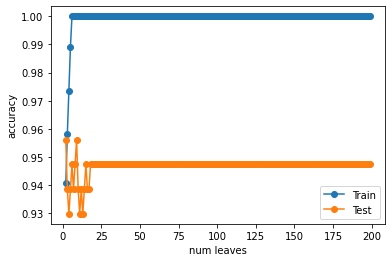

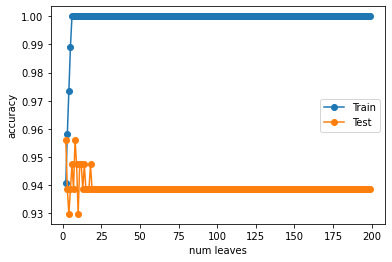

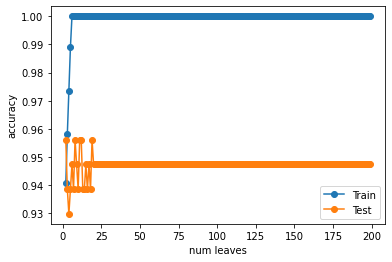

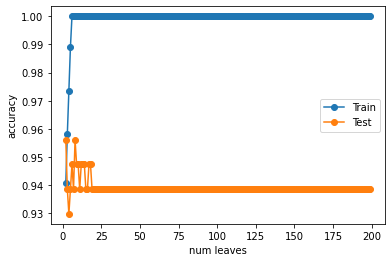

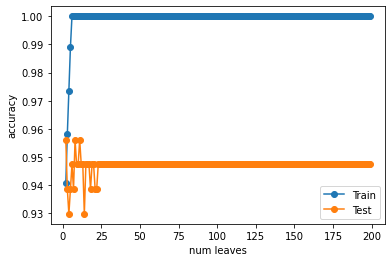

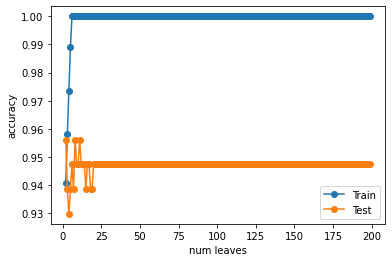

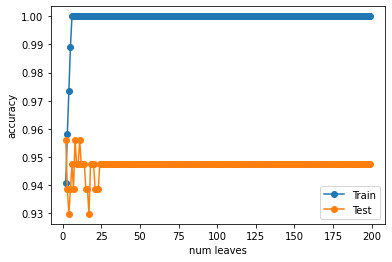

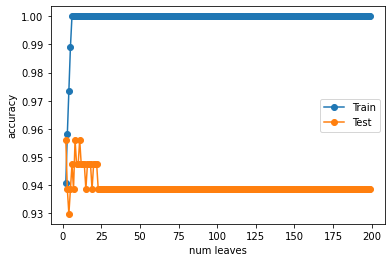

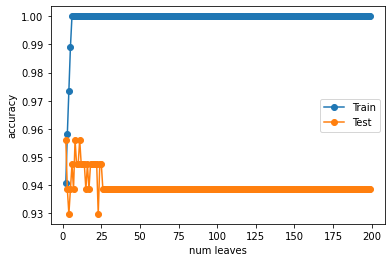

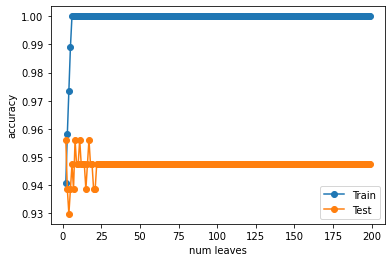

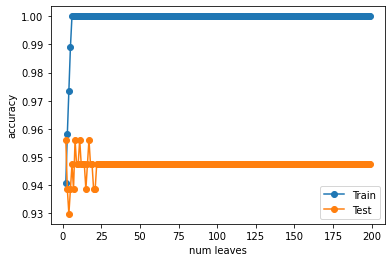

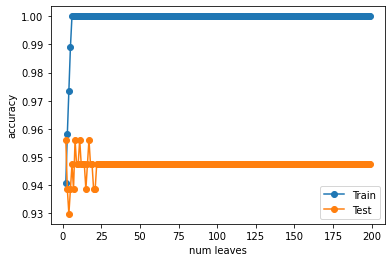

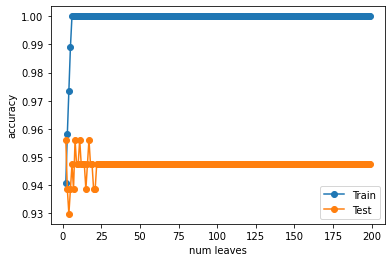

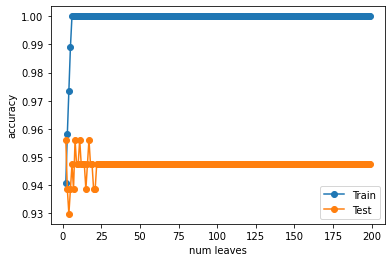

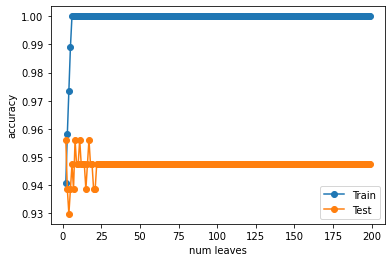

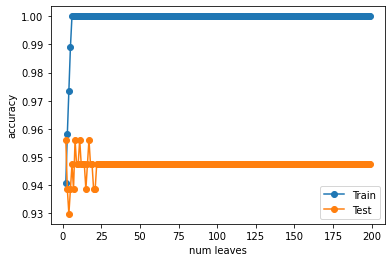

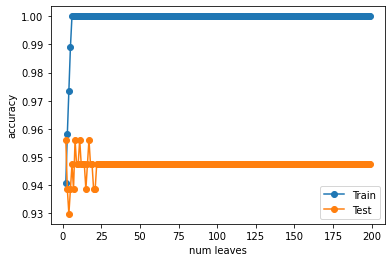

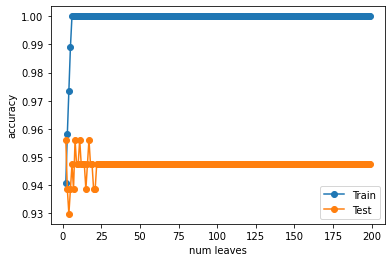

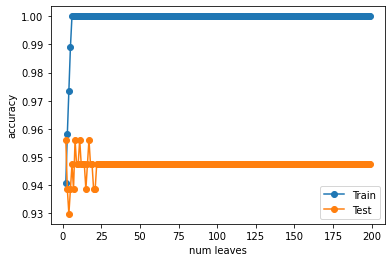

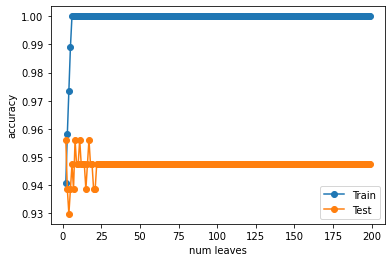

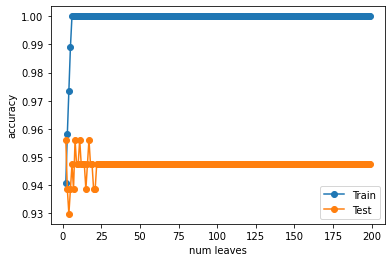

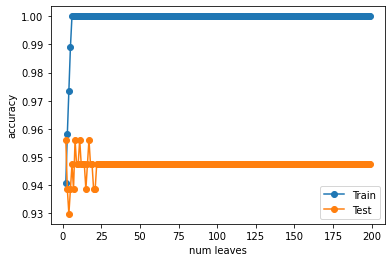

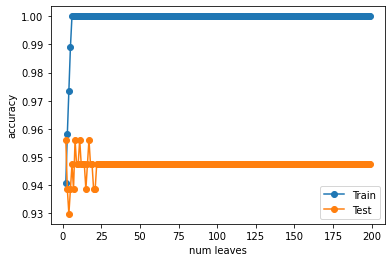

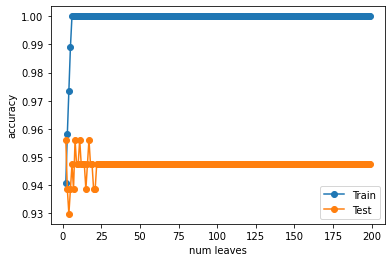

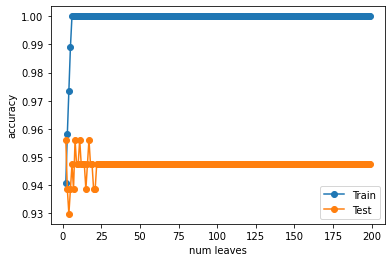

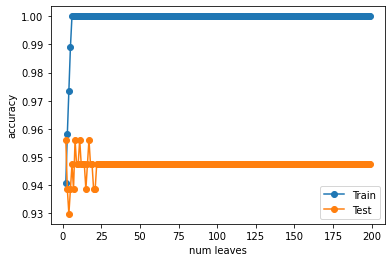

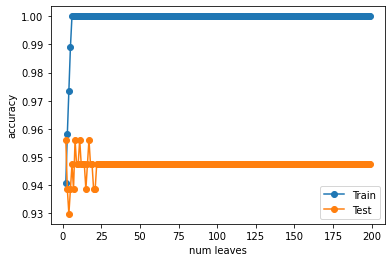

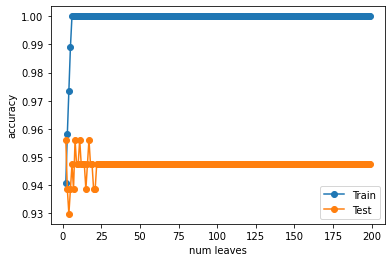

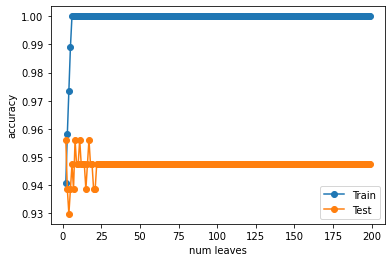

In [30]:
from matplotlib import pyplot
u=[]
r=[]
for i in range(2,35):
    acc1=[]
    acc2=[]
    lul=[]
    for j in range(2,200):
        model = LGBMClassifier(max_depth=i,num_leaves=j)
        model.fit(X1_train, Y1_train)
        p1 = model.predict(X1_test)
        p2=model.predict(X1_train)
        acc1.append(accuracy_score(Y1_test,p1))
        acc2.append(accuracy_score(Y1_train,p2))
        u.append(accuracy_score(Y1_test,p1))
        r.append(accuracy_score(Y1_train,p2))
        lul.append(j)
    pyplot.plot(lul, acc2, '-o', label='Train')
    pyplot.xlabel("num leaves")
    pyplot.plot(lul, acc1, '-o', label='Test')
    pyplot.ylabel("accuracy")
    pyplot.legend()
    pyplot.show()


In [31]:
acc1=[]
for i in np.linspace(0.01,0.9,num=11):
    for j in range(1,15):
        model = LGBMClassifier(learning_rate=i,n_estimators=j)
        model.fit(X1_train, Y1_train)
        p1 = model.predict(X1_test)
        acc1.append(accuracy_score(Y1_test,p1))
for i in acc1 :
    print(i)


0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.6491228070175439
0.9298245614035088
0.9298245614035088
0.9298245614035088
0.9298245614035088
0.9385964912280702
0.9385964912280702
0.9473684210526315
0.9385964912280702
0.9385964912280702
0.9385964912280702
0.9385964912280702
0.9473684210526315
0.6491228070175439
0.9298245614035088
0.9385964912280702
0.9385964912280702
0.9385964912280702
0.9385964912280702
0.9473684210526315
0.9473684210526315
0.9473684210526315
0.9385964912280702
0.9385964912280702
0.9473684210526315
0.9298245614035088
0.9473684210526315
0.9298245614035088
0.9298245614035088
0.9473684210526315
0.9473684210526315
0.956140350877193
0.9385964912280702
0.9473684210526315
0.9385964912280702
0.9298245614035088
0.9385964912280702
0.92105263157